In [1]:
import numpy as np

import tensorflow as tf

import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm


import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

/home/fractaluser/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fractaluser/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fractaluser/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fractaluser/a

In [2]:
from all_models import DavidNet

import run_util


from importlib import reload
reload(run_util)

from run_util import Run

import data_pipeline

reload(data_pipeline)

Using TensorFlow backend.


<module 'data_pipeline' from '/home/fractaluser/Personal/Narahari/eva_research/v2/eva_research_team4/src/data_pipeline.py'>

In [3]:
data_pipeline.get_data(dataset_name = "CIFAR10", tfrecords_flag=True)

saving to tf records
Instructions for updating:
Please write your own downloading logic.
Generating ../data/train/train.tfrecords
Generating ../data/eval/eval.tfrecords
getting tf records complete


In [4]:
BATCH_SIZE = 25 #@param {type:"integer"}
MOMENTUM = 0.95 #@param {type:"number"}

MIN_MOMENTUM = 0.8 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 1 #@param {type:"integer"}


MIN_LEARNING_RATE = 0.000001 #@param {type:"number"}

END_LR_SMOOTHING_PERC = 0.15 #@param {type:"number"}

COMMENTS = "Integration tests" #@param {type:"string"}


params_tune = {
    
  "epochs":EPOCHS, 
 
  "batch_size" : BATCH_SIZE,

  "max_lr": LEARNING_RATE,

  "min_lr":MIN_LEARNING_RATE,

  "end_anneal_pc":END_LR_SMOOTHING_PERC,

  "max_mom":MOMENTUM,
 
  "min_mom":MIN_MOMENTUM,
 
  "wd":WEIGHT_DECAY,
  
  "skip_testing_epochs":0,
    
  "batches_per_epoch":100//BATCH_SIZE,
    
  "comments":COMMENTS
}

In [5]:
loaded_tfrecs = data_pipeline.load_tfrecords(params_tune["batch_size"])

train_dataset = loaded_tfrecs["train"]

eval_dataset = loaded_tfrecs["eval"]

###### Running only on 50 images, just for integration tests

In [6]:
def tst_data_supplier(epoch_num):
    
    batch_size = params_tune["batch_size"]
    
    global eval_dataset
  
    len_test = 50

    test_set = eval_dataset.take(50).batch(batch_size).prefetch(1)
    
    return (test_set, len_test)

def trn_data_supplier(epoch_num):
    
    batch_size = params_tune["batch_size"]
  
    global train_dataset
    
    len_train = 50

    train_set = train_dataset.take(50).batch(batch_size).prefetch(1)
    
    return (train_set, len_train)

In [7]:
model_fn = DavidNet

obj = Run()

In [8]:
x = obj.run(model_fn, params_tune, trn_data_supplier, tst_data_supplier)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
epoch: 1 lr: 0.020000500000000004 train loss: 2.463 train acc:0.060 val loss: 2.364 val acc: 0.140 time:1.933

   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       1          25     0.4  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    1.936832       0.06      0.14  0.0005    2.463127   

   test_loss                                               runs  \
0   2.363993  {'epoch': [1], 'time': [1.9336421489715576], '...   

              log_time           comments  
0  2019-09-03 06:54:56  Integration tests  


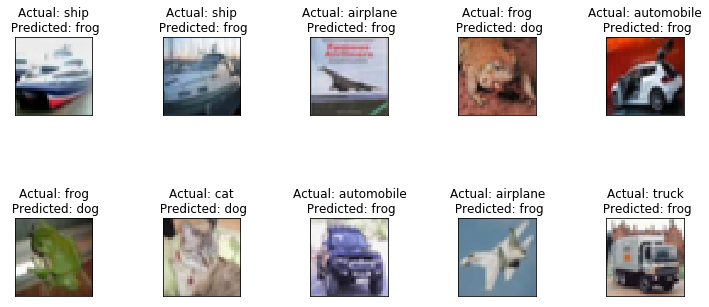

In [9]:
obj.show_missclassified_images(num_images=10, tst_data_supplier=tst_data_supplier)

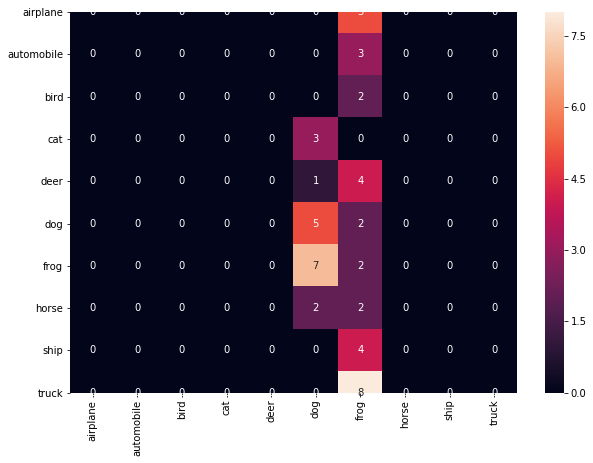

In [10]:
obj.plot_confusion_matrix(tst_data_supplier=tst_data_supplier)

### LR Finder

Creating a separate data supplier for lr finder

running lr_finder


1



2



3


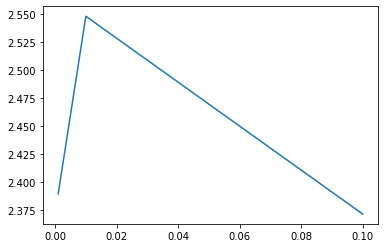

[[0.001, 0.01, 0.1],
 [2.389703826904297, 2.5484245300292967, 2.3718550872802733]]

In [11]:
obj.lr_finder(model_fn, lr_list=[0.001, 0.01, 0.1], tst_data_supplier=tst_data_supplier,
             trn_data_supplier=trn_data_supplier)

### Grid Search

In [12]:
params_tune_grid = {
    
  "epochs":[2, 3] ,
 
  "batch_size" : [16, 25],

  "max_lr": [0.1, 0.4],

  "min_lr":[MIN_LEARNING_RATE],

  "end_anneal_pc":[END_LR_SMOOTHING_PERC],

  "max_mom":[MOMENTUM],
 
  "min_mom":[MIN_MOMENTUM],
 
  "wd":[WEIGHT_DECAY],
  
  "skip_testing_epochs":[0],
    
  "batches_per_epoch":[50000//BATCH_SIZE],
    
   "comments":["GRID SEARCH RUNS"]
}

obj.grid_search(model_fn, params_tune_grid, trn_data_supplier, tst_data_supplier)


   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       2          16     0.1  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    3.397303       0.08      0.06  0.0005    2.451632   

   test_loss                                               runs  \
0   2.341633  {'epoch': [1, 2], 'time': [1.8279533386230469,...   

              log_time          comments  
0  2019-09-03 06:55:07  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       2          16     0.4  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    3.421345       0.12      0.08  0.0005    2.316013   

   test_loss                                               runs  \
0   2.334704  {'epoch': [1, 2], 'time': [1.8045012950897217,...   

              log_time          comments  
0  2019-09-03 06:55:10  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       2          25     0.1  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    3.337093       0.02      0.18  0.0005     2.60887   

   test_loss                                               runs  \
0   2.534968  {'epoch': [1, 2], 'time': [1.7697594165802002,...   

              log_time          comments  
0  2019-09-03 06:55:14  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       2          25     0.4  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    3.346182       0.08      0.08  0.0005    2.511127   

   test_loss                                               runs  \
0   2.365659  {'epoch': [1, 2], 'time': [1.761902093887329, ...   

              log_time          comments  
0  2019-09-03 06:55:17  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       3          16     0.1  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    4.968339       0.14       0.1  0.0005    2.486274   

   test_loss                                               runs  \
0    2.32517  {'epoch': [1, 2, 3], 'time': [1.76265525817871...   

              log_time          comments  
0  2019-09-03 06:55:22  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       3          16     0.4  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    4.979783       0.04      0.06  0.0005     2.42462   

   test_loss                                               runs  \
0   2.293442  {'epoch': [1, 2, 3], 'time': [1.78953599929809...   

              log_time          comments  
0  2019-09-03 06:55:27  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       3          25     0.1  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    4.944698       0.18      0.08  0.0005    2.301014   

   test_loss                                               runs  \
0   2.355996  {'epoch': [1, 2, 3], 'time': [1.75519990921020...   

              log_time          comments  
0  2019-09-03 06:55:32  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       3          25     0.4  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    4.967406       0.12      0.06  0.0005    2.379765   

   test_loss                                               runs  \
0    2.33608  {'epoch': [1, 2, 3], 'time': [1.80100154876708...   

              log_time          comments  
0  2019-09-03 06:55:37  GRID SEARCH RUNS  


({'epochs': 2,
  'batch_size': 25,
  'max_lr': 0.1,
  'min_lr': 1e-06,
  'end_anneal_pc': 0.15,
  'max_mom': 0.95,
  'min_mom': 0.8,
  'wd': 0.0005,
  'skip_testing_epochs': 0,
  'batches_per_epoch': 2000,
  'comments': 'GRID SEARCH RUNS'},
 0.18)

##### Viewing log

In [13]:
import pandas as pd

pd.read_csv("../data/run_logger.csv").tail()

,total_model_parameters,epochs,batch_size,max_lr,min_lr,anneal_perc,max_mom,min_mom,time_taken,train_acc,test_acc,wd,train_loss,test_loss,runs,log_time,comments
115,343264,2,25,0.4,0.000001,0.15,0.95,0.8,3.346182,0.08,0.08,0.0005,2.511127,2.365659,"{'epoch': [1, 2], 'time': [1.761902093887329, ...",2019-09-03 06:55:17,GRID SEARCH RUNS
116,343264,3,16,0.1,0.000001,0.15,0.95,0.8,4.968339,0.14,0.10,0.0005,2.486274,2.325170,"{'epoch': [1, 2, 3], 'time': [1.76265525817871...",2019-09-03 06:55:22,GRID SEARCH RUNS
117,343264,3,16,0.4,0.000001,0.15,0.95,0.8,4.979783,0.04,0.06,0.0005,2.424620,2.293442,"{'epoch': [1, 2, 3], 'time': [1.78953599929809...",2019-09-03 06:55:27,GRID SEARCH RUNS
118,343264,3,25,0.1,0.000001,0.15,0.95,0.8,4.944698,0.18,0.08,0.0005,2.301014,2.355996,"{'epoch': [1, 2, 3], 'time': [1.75519990921020...",2019-09-03 06:55:32,GRID SEARCH RUNS
119,343264,3,25,0.4,0.000001,0.15,0.95,0.8,4.967406,0.12,0.06,0.0005,2.379765,2.336080,"{'epoch': [1, 2, 3], 'time': [1.80100154876708...",2019-09-03 06:55:37,GRID SEARCH RUNS


#### Numpy implementation